In [31]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [32]:
file_path = "../../Datasets/Data.xlsx"
data_title = "data_Flex_raw_data"
val_split, test_split = 0.2, 0.1
TRAIN_SPLIT = 1001

In [33]:
# Load data
table_of_contents = pd.read_excel(file_path, sheet_name=0, header=None)
sheet_index = table_of_contents[table_of_contents[0] == data_title][0].index[0]
sheet_data = pd.read_excel(file_path, sheet_name=sheet_index + 1, header=None)
sheet_data.columns = ['1' ,'2', '3', '4', '5', '6', '7', '8', 'N/A_1', 'N/A_2', 'angle', 'time', 'session']
rearranged_cols_force = ['time', '1' ,'2', '3', '4', '5', '6', '7', '8']
rearranged_cols_angle = ['time', 'angle']
rearranged_cols_sensors_time_invariant = rearranged_cols_force[1:] + rearranged_cols_angle[1:]

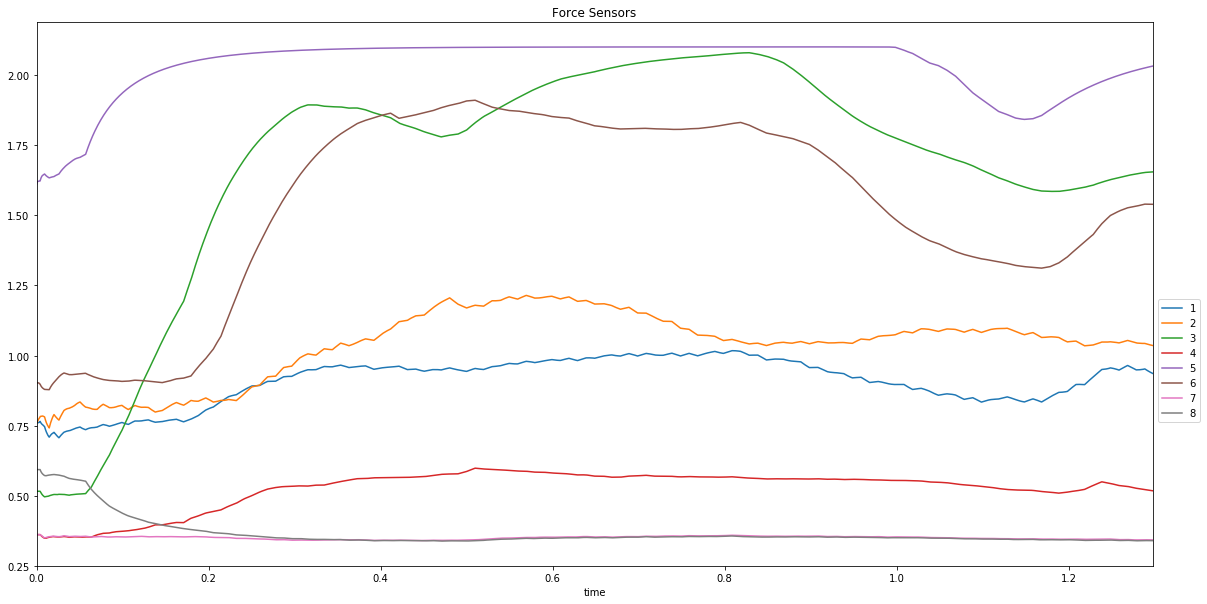

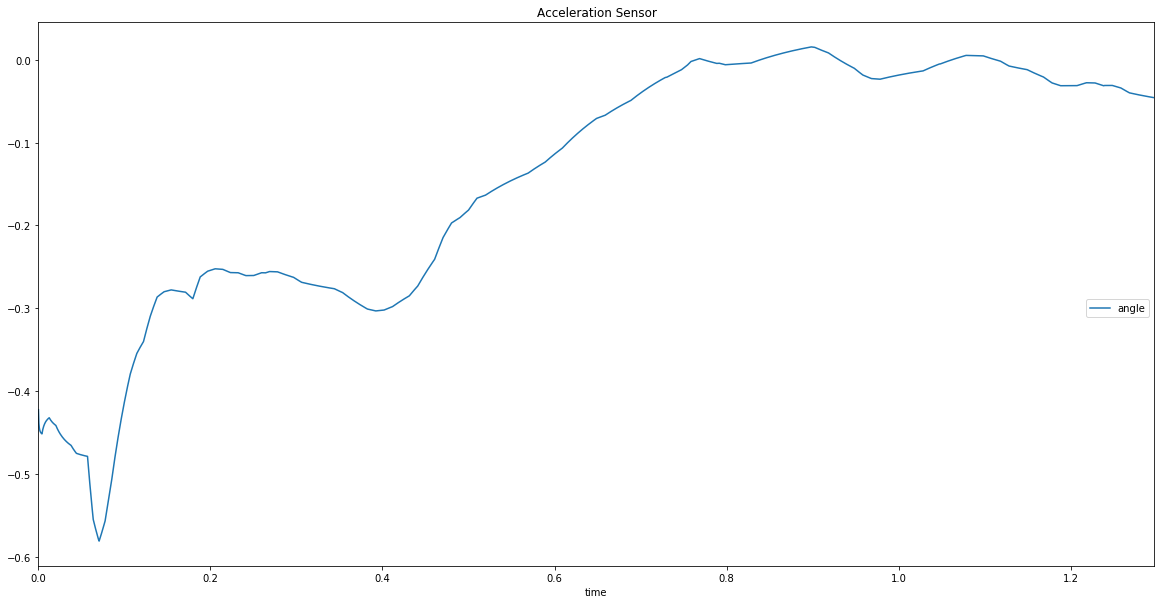

In [34]:
# Plot data

# data['time'] = data['time'].apply(lambda x : x - data['time'][0])
# Move times such that they start at 0

def plot_sensorband_dataframe(df, title):
    plt = df.plot(x='time')
    plt.legend(bbox_to_anchor=(1.0, 0.5))
    plt.set_title(title)
    
SMOOTHING = 200


data_force = sheet_data[rearranged_cols_force].ewm(span=SMOOTHING).mean()
plot_sensorband_dataframe(data_force, "Force Sensors")
data_angle = sheet_data[rearranged_cols_angle].ewm(span=SMOOTHING).mean()
plot_sensorband_dataframe(data_angle, "Acceleration Sensor")

#data_angle = data_angle['angle'].ewm(span = 10).mean()
#data_all_features = sheet_data[rearranged_cols_sensors_time_invariant]

In [35]:
features_considered = ['1' ,'2', '3', '4', '5', '6', '7', '8', 'angle', 'time']
features = sheet_data[features_considered].ewm(span=SMOOTHING).mean()
#features.index = sheet_data['time']
features = features.drop('time', axis=1)
target = features['angle']
features = features.drop('angle', axis=1)
features.head(5)

,1,2,3,4,5,6,7,8
0,0.760547,0.760547,0.515625,0.360937,1.611328,0.902344,0.360937,0.592969
1,0.760547,0.760547,0.515625,0.360937,1.617806,0.902344,0.360937,0.592969
2,0.760547,0.764887,0.515625,0.360937,1.619965,0.902344,0.360937,0.592969
3,0.760547,0.767057,0.515625,0.360937,1.621044,0.902344,0.360937,0.592969
4,0.760547,0.770988,0.515625,0.360937,1.621692,0.902344,0.360937,0.592969


In [36]:
#features.plot(subplots=True)
target.head(5)

0   -0.422477
1   -0.438888
2   -0.444358
3   -0.447093
4   -0.448734
Name: angle, dtype: float64

In [37]:
#Normalize

from sklearn import preprocessing

x = features.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
dataset = pd.DataFrame(x_scaled)
dataset = dataset.values

x = target.values #returns a numpy array
x = x.reshape(-1, 1)
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
target = pd.DataFrame(x_scaled)
target = target.values

#dataset = features.values
#data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
#data_std = dataset[:TRAIN_SPLIT].std(axis=0)
#dataset = (dataset-data_mean)/data_std

#target = target.values
#target_mean = target.mean(axis=0)
#target_std = target.std(axis=0)
#target = (target-target_mean)/target_std

#plt.plot(dataset)

In [38]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])
            
    return np.array(data), np.array(labels)

def create_time_steps(length):
    time_steps = []
    for i in range(-length, 0, 1):
        time_steps.append(i)
    return time_steps

def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo', label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro', label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

In [39]:
past_history = 100
future_target = 0
STEP = 1

x_train, y_train = multivariate_data(dataset, target, 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP, single_step=True)
x_val, y_val = multivariate_data(dataset, target,
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP, single_step=True)

#print ('Single window of past history : {}'.format(x_train[0].shape))
#print ('\n Target to predict : {}'.format(y_train[0]))
print(len(x_train))
print(len(x_val))


print("DATA:")
print(x_train[1])
print("LABEL:")
print(y_train[1])

901
297
DATA:
[[1.73945086e-01 4.00591740e-02 1.25614723e-02 5.13307882e-02
  1.32240104e-02 2.34455242e-02 1.00000000e+00 1.00000000e+00]
 [1.73945086e-01 4.92372708e-02 1.25614723e-02 5.13307882e-02
  1.76318669e-02 2.34455242e-02 1.00000000e+00 1.00000000e+00]
 [1.73945086e-01 5.38260898e-02 1.25614723e-02 5.13307882e-02
  1.98356850e-02 2.34455242e-02 1.00000000e+00 1.00000000e+00]
 [1.73945086e-01 6.21410302e-02 1.25614723e-02 5.13307882e-02
  2.11578877e-02 2.34455242e-02 1.00000000e+00 1.00000000e+00]
 [1.73945086e-01 6.76838619e-02 1.25614723e-02 5.13307882e-02
  2.20392827e-02 2.34455242e-02 1.00000000e+00 1.00000000e+00]
 [1.80050611e-01 7.16426316e-02 1.25614723e-02 5.13307882e-02
  2.26687876e-02 2.16084206e-02 1.00000000e+00 1.00000000e+00]
 [1.84629221e-01 7.81394701e-02 1.25614723e-02 5.13307882e-02
  2.31408612e-02 2.02307536e-02 1.00000000e+00 1.00000000e+00]
 [1.88189887e-01 8.31918932e-02 1.25614723e-02 5.13307882e-02
  2.35079807e-02 1.91593777e-02 1.00000000e+00 1.

In [40]:
BATCH_SIZE = 1
#BUFFER_SIZE = 1000

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).repeat()
train_data = train_data.cache().batch(BATCH_SIZE)

val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val)).repeat()
val_data = val_data.batch(BATCH_SIZE).repeat()


#for x, y in val_data.take(0):
#    multi_step_plot(x[0], y[0], np.array([0]))

In [41]:
# This model works pretty fucking well!
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, input_shape=x_train[0].shape, activation='relu'),
    tf.keras.layers.LSTM(128, return_sequences=True, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.LSTM(32, return_sequences=True, activation='relu'),
    tf.keras.layers.Dropout(0.01),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.005),
    tf.keras.layers.LSTM(8, return_sequences=False, activation='relu'),
    tf.keras.layers.Dense(1)
])

N = pow(2,8)//2
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(8, input_shape=x_train[0].shape, activation='relu'),
    tf.keras.layers.LSTM(16,input_shape=x_train[0], return_sequences=False, activation='relu'),
    #tf.keras.layers.Dropout(0.1),
    #tf.keras.layers.Dense(N//4, activation='relu'),
    #tf.keras.layers.Dropout(0.05),
    #tf.keras.layers.LSTM(N//8, return_sequences=True, activation='relu'),
    #tf.keras.layers.Dropout(0.01),
    #tf.keras.layers.Dense(N//16, activation='relu'),
    #tf.keras.layers.Dropout(0.005),
    #tf.keras.layers.LSTM(N//32, return_sequences=False, activation='relu'),
    tf.keras.layers.Dense(1)
])


model.compile(optimizer='sgd', loss='mse')
#model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mean_squared_error')

In [ ]:
EPOCHS = 3
EVALUATION_INTERVAL = len(x_train)//1
VAL_STEPS = len(x_val)//BATCH_SIZE


print(x_train[0].shape)

#for x in range(0, 10):
multi_step_history = model.fit(train_data, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data,
                                          validation_steps=VAL_STEPS)

(100, 8)
Train for 901 steps, validate for 297 steps
Epoch 1/3
651/901 [====================>.........] - ETA: 25s - loss: 0.0029

In [ ]:
res = model.predict(train_data.take(len(x_train)))
res2 = model.predict(val_data.take(len(x_val)))

Y = train_data.take(1)
X = model.predict(Y)
print(Y)
print(X)

#print(res)
from itertools import chain
res = list(chain(*res))
res2 = list(chain(*res2))

plt.rcParams["figure.figsize"] = (20,10)

fig=plt.figure()
fig.show()
ax=fig.add_subplot(111)

import pylab
ax.plot(res + res2, label='predicted')
ax.plot(target, label='truth')
pylab.legend(loc='upper left')
plt.show()